In [1]:
# Set seeds for reproducible results
from numpy.random import seed
seed(327)
import tensorflow
tensorflow.random.set_seed(327)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import itertools

Using TensorFlow backend.


#### Helper Functions

##### 1. Data Preprocessing

In [2]:
def preprocess_data(raw_data):
    
    # Add categorical dummy variables (All 0s represent)
    tasknum_dummies = pd.get_dummies(raw_data['Task_num'],
                                     prefix="TaskNum") # Create dummy variables
    data = pd.concat([raw_data, tasknum_dummies], axis=1) 

    # Remove the unnecessary columns
    remove_cols = ["Skip_distance",
              "Subject",
              "Mean_fixation_duration",
              "Loag_Fixationtime",
              "Log_timetoF",
              "Task_completion_duration",
              "Compressed_scanpath_value", 
              "Total_r_d",
              "Compressed_M_Minimal",
              "Strictly_linearWID",
              "Mean_fixation_duration_for_onelink",
              "Skip",
              "Skip_count", 
              "Task_num",
              "TaskNum_t9"]  # Remove one dummy variable to avoid the dummy variable trap

    data = data.drop(remove_cols, axis=1)
    
    # Encode the Screen_size column
    vals = ['S', 'M', 'L']
    for i in range(len(vals)):
        data.at[data['Screen_size'] == vals[i], ['Screen_size']] = i    

    # Replace missing values with 0 in column Regression_distance
    preprocessed_data = data.fillna(0)

    # Inspect the number of missing values in the preprocessed_data dataset
    num_missing = preprocessed_data.isnull().sum().sum()
    print("The number of missing values in the data = {}".format(num_missing))
    print("Number of features remaining = {}".format(data.shape[1]))
    
    return preprocessed_data

##### 2. Model Building

In [3]:
def create_model(hidden_neurons, learning_rate, num_epoch, input_neurons = 29, output_neurons=3):
    
    # define the structure of our neural network
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    return net, loss_func, optimiser

##### 3. Train Model

In [4]:
def train_neural_network(model, X_train, y_train):
    
    # create Tensors to hold inputs and outputs. Tensors are data structures
    # similar to numpy matrices. They can be operated on efficiently by a GPU
    # 
    # Note: In torch versions before 0.4, Tensors had to be wrapped in a Variable
    # to be used by the NN.
    X = torch.tensor(X_train.values, dtype=torch.float)
    Y = torch.tensor(y_train.values, dtype=torch.long)
    
    
    # store all losses for visualisation
    all_losses = []

    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)

        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())

        # print progress
#         if epoch % 50 == 0:
#             # convert three-column predicted Y values to one column for comparison
#             _, predicted = torch.max(F.softmax(Y_pred,1), 1)

#             # calculate and print accuracy
#             total = predicted.size(0)
#             correct = predicted.data.numpy() == Y.data.numpy()

#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        net.zero_grad()

        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        
    return np.array(all_losses)

##### 4. Evaluate Model

In [5]:
def evaluate(net, x, y, mode='Train'):
    
    # Transform data to tensors
    X = torch.tensor(x.values, dtype=torch.float)
    Y = torch.tensor(y.values, dtype=torch.long) 

    # Create empty 3x3 confusion matrix
    confusion = torch.zeros(3, 3)

    # Make predictions on X
    Y_pred = net(X)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)

    # Create confusion Matrix
    for i in range(X.shape[0]):
        actual_class = Y.data[i]
        predicted_class = predicted.data[i]

        confusion[actual_class][predicted_class] += 1

    # Calculate Accuracy score
    correct_pred_count = confusion[0,0] + confusion[1,1] + confusion[2,2]
    accuracy_score = correct_pred_count / confusion.sum() * 100

    print("{}ing Accuracy = {}%".format(mode, accuracy_score))    
    print('Confusion matrix for {}ing:'.format(mode))
    print(confusion.numpy())
    
    print("\nClassification Report -")
    print(metrics.classification_report(y, predicted.numpy()))

#### Data Preparation

In [6]:
# Step 1. Import the dataset

# Total number of columns in the dataset = 36
required_cols = list(range(36))

# Read the dataset
raw_data = pd.read_excel("Jae-Second_Exp_data.xlsx",
                     sheet_name="Analysis_summary",
                     nrows=161,
                     usecols = required_cols)

# Step 2. Preprocess the data
data = preprocess_data(raw_data = raw_data)

# Step 3. Split the data into training and test sets

# Divide into features and target variables
X = data.drop("Screen_size", axis=1)
y = data['Screen_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

The number of missing values in the data = 0
Number of features remaining = 30


#### Model Building

In [7]:
# # Step 4. Initialise model parameters
# hidden_neurons = 32
# learning_rate = 0.474
# num_epoch = 200

# # Step 5. Build model skeleton
# net, loss_func, optimiser = create_model(hidden_neurons=hidden_neurons,
#                                          learning_rate=learning_rate,
#                                          num_epoch=num_epoch)

# # Step 6. Train the model and store build history
# losses = train_neural_network(net, X_train, y_train)

#### Model evaluation

In [8]:
# # Step 7. Evaluate on train and test data
# evaluate(net, X_train, y_train)
# evaluate(net, X_test, y_test, mode='Test')

## Hyperparamter tuning using Genetic Algorithm

We wish to tune the following hyperparameters for our neural network architecture :
1. Number of hidden layers
2. Neurons per layer
3. Activation Function for the hidden layers
4. Optimizer

##### C. Initialise Population

In [9]:
# Step 3. Create the initial population
def initialise_population(population_size):    
    num_parameters = 3  # Number of hyperparameters we wish to tune    
    # Initialize search space
    population = np.zeros((population_size, num_parameters))    
 
    # Add individuals to the population
    for i in range(population_size):
        # a) Randomly choose attributes from the search space
        nhl = np.random.choice(num_hidden_layers)
        npl = np.random.choice(neurons_per_layer)
        dpt = np.random.choice(dropout)
        # b) Add individual with chosen attributes to the population
        population[i,:] = nhl, npl, dpt        
    return population

##### D. Get the fitness score of the members of a population

In [10]:
# Primary function: get_pop_fitness

# Helper functions : 
    # a) translate_params
    # b) build_nn
    # c) get_individual_fitness

def translate_params(params):
    params = params.tolist()
    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = params[2]
    return params

def build_nn(num_hidden_layers, neurons_per_layer, dropout):
    
    activation_function, optimizer = 'relu', 'adam'
    
    # Initialising the ANN
    classifier = Sequential()

    # Add first hidden layer
    classifier.add(Dense(units = neurons_per_layer, activation = activation_function, input_dim = X_train.shape[1]))

    # Add hidden layers
    for i in range(num_hidden_layers - 1):
        classifier.add(Dense(units = neurons_per_layer, activation = activation_function))
        classifier.add(Dropout(dropout, seed=327))
        
    # Adding the output layer
    classifier.add(Dense(units = 3, activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

def get_individual_fitness(individual):
    
    # Get parameters from individual
    num_hidden_layers, neurons_per_layer, dropout = translate_params(individual)
    
    model_params = {'num_hidden_layers':[num_hidden_layers], 
                    'neurons_per_layer':[neurons_per_layer],
                    'dropout':[dropout]}    
    # create model
    model = KerasClassifier(build_fn=build_nn, epochs=20, batch_size=10, verbose=0)    
    # Perform k-fold cross validation (using GridSearch here to reduce code size)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=327)
    model_cv = GridSearchCV(estimator=model, param_grid=model_params, scoring='f1_weighted', cv=kfold, n_jobs=-1)
    model_cv.fit(X_train, y_train)
    # Return weighted F1-score 
    return model_cv.cv_results_['mean_test_score'][0]

def get_pop_fitness(pop):
    # Initialize empty list of fitness scores
    fit_score = [] 
    # Loop over every member of the population
    for individual in pop: 
        fitness = get_individual_fitness(individual)
        # Add member fitness to record of population fitness
        fit_score.append(fitness)
    # Return the list of fitness scores of the entire population  
    return np.array(fit_score)

##### E. Selecting the best parents in the population for mating

In [11]:
def select_fittest_individuals(population, fitness_scores, n):
    return population[fitness_scores.argsort()[::-1]][:n]

##### F. Reproduction (Single-Point-Crossover)

In [12]:
# Step 6. Generating next generation using crossover

def single_point_crossover(fittest_individuals, n):
    children = []
    # Generate all possible pairs of Fit Individuals for reproduction
    for a, b in itertools.combinations(np.arange(len(fittest_individuals)), 2):        
        # Initialise parents
        parent_A = fittest_individuals[a].copy()
        parent_B = fittest_individuals[b].copy()
        # Randomly select a gene to be switched between both parents
        crossover_idx = np.random.randint(0, 3)
        # Switch that gene between the parents
        parent_B[crossover_idx], parent_A[crossover_idx] = parent_A[crossover_idx], parent_B[crossover_idx]
        # These modified parents are the children for the next generation
        children.append(parent_A)
        children.append(parent_B)
    
    # Indices of all the children 
    all_child_ids = np.arange(len(children))
    # Randomly select 'n' children that survive to the next generation
    survived_child_ids = np.random.choice(all_child_ids, n, replace=False).astype(int)
    children = np.array(children)[survived_child_ids]
    
    return children

##### G. Mutation (all children are mutated)

In [13]:
# Step 7. Adding some variations to the new generation
def mutate(survivors):
    
    m_survivors = survivors.copy()
    
    for survivor in m_survivors:
        # Randomly select a gene to mutate
        gene_id = np.random.randint(0, 3)
        
        # Determine if the mutation is an addition/subtraction operation (50-50 chance of either)
        p = 0.5
        sign = 1 if (np.random.random() > p) else -1

        # Mutate the genes (0 or 1) using values drawn from a gaussian distribution
        if gene_id == 0:
            factor = 3
            mutation = int(np.random.random() * factor)
            survivor[gene_id] += mutation    
            if survivor[gene_id] < 0:
                survivor[gene_id] = 0

        if gene_id == 1:
            factor = 10
            mutation = int(np.random.random() * factor)
            survivor[gene_id] += mutation
            if survivor[gene_id] <= 0:
                survivor[gene_id] = 2
                
        if gene_id == 2:
            factor = 10
            mutation = int(np.random.random() / factor)
            survivor[gene_id] += mutation
            if survivor[gene_id] <= 0:
                survivor[gene_id] = 0
            elif survivor[gene_id] >= 1:
                survivor[gene_id] = 0.99
    
    return m_survivors

In [14]:
# Define sample space for initial population
num_hidden_layers = np.arange(0, 10)
neurons_per_layer = np.arange(5, 100, 5)
# activation_functions = np.array(['relu', 'tanh', 'selu', 'softsign'])    
# optimizers = np.array(['sgd', 'rmsprop', 'adam', 'adadelta', 'adagrad', 'adamax', 'nadam'])   
dropout = np.random.random(size=30) / 2

In [15]:
%%time
# Step 1. Represent parameters as a chromosome

# Step 2. Defining the population size and number of generations
POPULATION_SIZE = 100
NUM_GENERATIONS = 20

NUM_PARENTS_PER_GENERATION = 30
NUM_CHILDREN_PER_GENRATION = 50
NUM_WEAK_SURVIVORS = POPULATION_SIZE - (NUM_PARENTS_PER_GENERATION + NUM_CHILDREN_PER_GENRATION)

# Book keeping variables
BEST_PERFORMERS = []
BEST_PERFORMERS_FITNESS = []

# Step 3. Creating the initial population.
population = initialise_population(POPULATION_SIZE)

# Repeat for each generation the following
for i in range(NUM_GENERATIONS):
    
    print("Generation {} begins:".format(i+1))
    
    old_population = population
    
    # Step 4. Measure the fitness of each chromosome in the population.
                # by Training and evaluating (f1-scores) for all networks in the population:
    print("    1. Assessing Population Fitness ...")
    fitness_scores = get_pop_fitness(old_population)
    
    print("    2. Selecting Fittest Individuals for Reproduction ...")
    # Step 5. Selecting the best parents in the population for mating.
    fittest_individuals = select_fittest_individuals(old_population, fitness_scores, NUM_PARENTS_PER_GENERATION)
    
    BEST_PERFORMERS.append(fittest_individuals)
    BEST_PERFORMERS_FITNESS.append(np.sort(fitness_scores)[::-1][:len(fittest_individuals)])
    
    print("    3. In Reproduction Stage ...")
    # Step 6. Generating next generation using single-point crossover.
    children = single_point_crossover(fittest_individuals, NUM_CHILDREN_PER_GENRATION)
    
    print("    4. Mutating children and weaklings ...")
    # Step 7. Adding some variations to the population using mutation on children and few weak members.
    children = mutate(children)
    weak_survivors = old_population[fitness_scores.argsort()][:NUM_WEAK_SURVIVORS] # Members with least fitness scores
    weak_survivors = mutate(weak_survivors)
    
    print("    5. Determining survivors for next generation ...")
    # Step 8. Creating the new population (Fittest, Weakest, Children)
    population = np.concatenate((fittest_individuals, children, weak_survivors), axis=0)
    
    print("    6. Strongest individual of Generation {} ...".format(i+1))
    # Step 9. Displaying the best result in the current generation
    generation_best_individual = old_population[fitness_scores.argmax()]
    generation_best_individual = translate_params(generation_best_individual)
    print(generation_best_individual, fitness_scores.max())

# Get the best solution

Generation 1 begins:
    1. Assessing Population Fitness ...
    2. Selecting Fittest Individuals for Reproduction ...
    3. In Reproduction Stage ...
    4. Mutating children and weaklings ...
    5. Determining survivors for next generation ...
    6. Strongest individual of Generation 1 ...
[1, 75, 0.2367354478873675] 0.414518037174384
Generation 2 begins:
    1. Assessing Population Fitness ...
    2. Selecting Fittest Individuals for Reproduction ...
    3. In Reproduction Stage ...
    4. Mutating children and weaklings ...
    5. Determining survivors for next generation ...
    6. Strongest individual of Generation 2 ...
[1, 95, 0.1304966883652316] 0.41466499070245194
Generation 3 begins:
    1. Assessing Population Fitness ...
    2. Selecting Fittest Individuals for Reproduction ...
    3. In Reproduction Stage ...
    4. Mutating children and weaklings ...
    5. Determining survivors for next generation ...
    6. Strongest individual of Generation 3 ...
[1, 89, 0.12316073

In [19]:
# np.save("Parents from Kfold Final(Add Dropout and mutate ALL)", BEST_PERFORMERS)
# np.save("Fitness from Kfold Final(Add Dropout and mutate ALL)", BEST_PERFORMERS_FITNESS)

In [16]:
b = np.array(BEST_PERFORMERS).reshape((-1, 3))
bf = np.array(BEST_PERFORMERS_FITNESS).ravel()

In [17]:
df_fit = pd.DataFrame(b, columns=['num_hidden_layers', 'neurons_per_layer', 'dropout'])
df_fit['fitness_score'] = bf
df_fit = df_fit.sort_values(by='fitness_score', ascending=False)
df_fit

num_hidden_layers  neurons_per_layer   dropout  fitness_score
390                1.0               39.0  0.258918       0.475403
420                1.0               77.0  0.258918       0.456215
421                1.0               49.0  0.159685       0.450335
210                1.0               68.0  0.159685       0.448779
570                1.0               38.0  0.159685       0.446150
..                 ...                ...       ...            ...
25                 1.0               85.0  0.311791       0.353949
26                 0.0               80.0  0.123161       0.353554
27                 0.0               15.0  0.132786       0.353433
28                 4.0               90.0  0.186952       0.352699
29                 3.0               30.0  0.258918       0.352616

[600 rows x 4 columns]

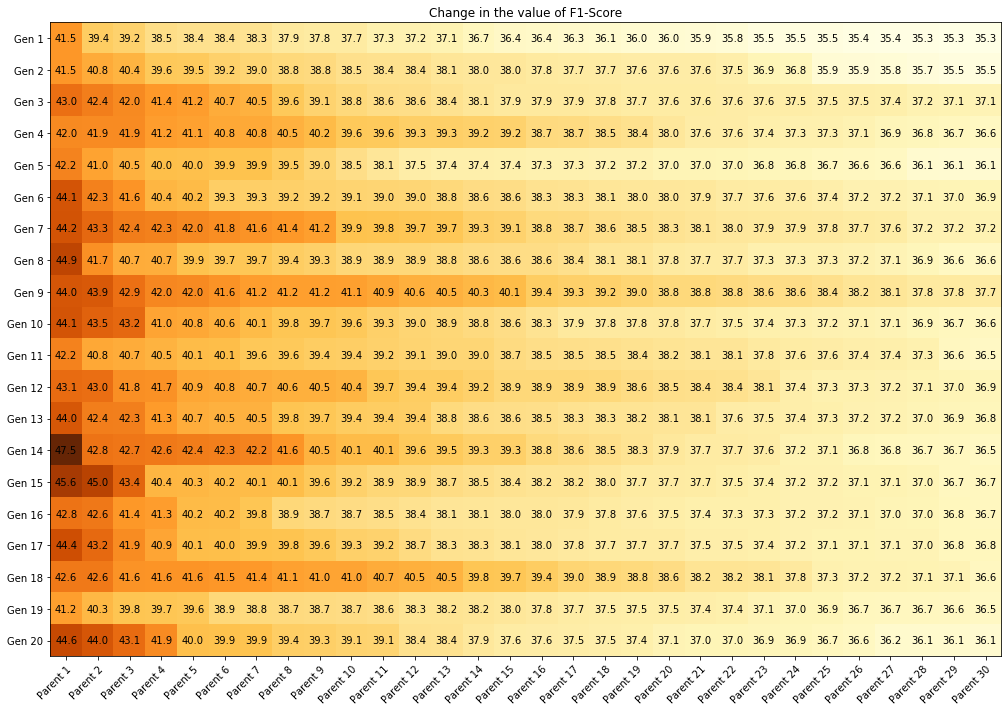

In [18]:
def plot_parameters(numberOfGenerations, numberOfParents, parameter, parameterName):
    #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
    generationList = ["Gen {}".format(i+1) for i in range(numberOfGenerations)]
    populationList = ["Parent {}".format(i+1) for i in range(numberOfParents)]
    
    fig, ax = plt.subplots(figsize=(20,10))
    im = ax.imshow(parameter, cmap=plt.get_cmap('YlOrBr'))
    
    # show ticks
    ax.set_xticks(np.arange(len(populationList)))
    ax.set_yticks(np.arange(len(generationList)))
    
    # show labels
    ax.set_xticklabels(populationList)
    ax.set_yticklabels(generationList)
    
    # set ticks at 45 degrees and rotate around anchor
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    # insert the value of the parameter in each cell
    for i in range(len(generationList)):
        for j in range(len(populationList)):
            text = ax.text(j, i, np.round(np.array(parameter)*100,1)[i, j],
                           ha="center", va="center", color="k")
    
    ax.set_title("Change in the value of " + parameterName)
    fig.tight_layout()
    plt.show()

plot_parameters(NUM_GENERATIONS, NUM_PARENTS_PER_GENERATION, BEST_PERFORMERS_FITNESS, "F1-Score")